# Functions

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import ndimage

import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [20]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [3]:
exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20210908\\SplitData\\'

In [4]:
dt = 0.01
sampling_rate = 20000

Mean = 10
amp_list = [0.5,1,1.5,2,3]

x_list = []
T_list = []
for amp in amp_list:
    filename = 'diode_OU_tau=500ms_cutoff=1_mean='+str(Mean)+'_amp='+str(amp)+'_11-Aug-2021_0'
    annots = loadmat(exp_folder+filename)
    TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
    print(TimeStamps)
    TimeStamps = TimeStamps.astype(int)
    x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect')
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x-np.mean(x))/np.std(x)
    x_list.append(x.copy())
    T_list.append( np.arange(len(x))*dt )
    # XcT = T-T[int(len(T)/2)]

[306. 606.]
[306. 605.]
[307. 606.]
[307. 606.]
[307. 606.]


(0.0, 500.0)

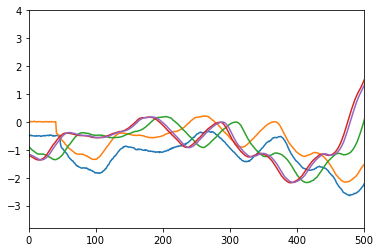

In [5]:
for x in x_list:
    plt.plot(x)
plt.xlim(0,500)

In [6]:
Mean = 10
amp_list = [0.5,1,1.5,2,3]
WNSTA_list = []
ExpSTA_list = []
for amp in amp_list:
    filename = 'diode_WhiteNoise_mean='+str(Mean)+'_amp='+str(amp)+'_11-Aug-2021_0'
    loadfiles = np.load(exp_folder+'STA\\STA_'+filename+'.npz', allow_pickle=True)
    for k in loadfiles.files:
        vars()[k] = loadfiles[k][()]
    WNSTA_list.append(STA_cell.copy())

    filename = 'diode_OU_tau=500ms_cutoff=1_mean='+str(Mean)+'_amp='+str(amp)+'_11-Aug-2021_0'
    loadfiles = np.load(exp_folder+'STA\\STA_'+filename+'.npz', allow_pickle=True)
    for k in loadfiles.files:
        vars()[k] = loadfiles[k][()]
    ExpSTA_list.append(STA_cell.copy())

# Expt. STA

In [7]:
cn = 30

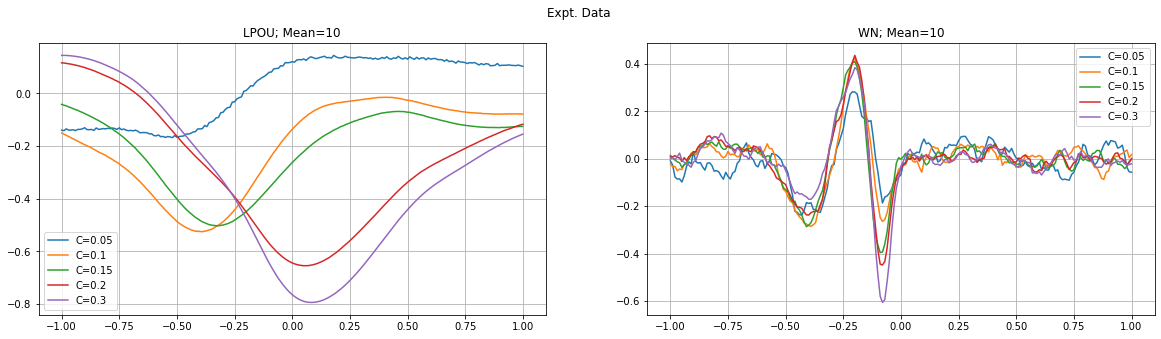

In [13]:
fig, ax = plt.subplots(1,2)
for i in range(len(amp_list)):
    ax[0].plot(timeshift, ExpSTA_list[i][cn-1], label = 'C='+str(round(amp_list[i]/Mean,3)))
    ax[1].plot(timeshift, WNSTA_list[i][cn-1], label = 'C='+str(round(amp_list[i]/Mean,3)))
for axi in ax:
    axi.legend()
    axi.grid('on')

ax[0].set_title('LPOU; Mean='+str(Mean))
ax[1].set_title('WN; Mean='+str(Mean))
# ax[1].set_xlim(-1,0)

fig.suptitle('Expt. Data')
fig.set_size_inches(20,5)

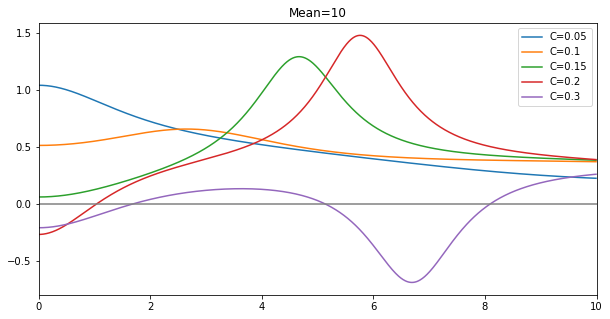

In [24]:
domega = 0.01
omega = np.arange(-1,10,domega) #limited by [pi/dt,pi/dt)
for i in range(len(amp_list)):
    TKdw = np.sum(WNSTA_list[i][cn-1][np.newaxis,:]*np.exp(-1j*np.abs(timeshift[np.newaxis,:])*omega[:,np.newaxis]), axis = 1)*dt
    phi = np.angle(TKdw)
    delta = -angular_gradient(phi)/domega
    plt.plot(omega, delta,label = 'C='+str(round(amp_list[i]/Mean,3)))
plt.xlim(0,10)
plt.axhline(0, c='grey')
plt.legend()
plt.title('Mean='+str(Mean))
plt.gcf().set_size_inches(10,5)

# WNSTA convolve LPOU (LN model)

In [14]:
r_list = [0]*len(amp_list)
DCCM_Xcorr = [0]*len(amp_list)
for i in range(len(amp_list)):
    x = x_list[-1]
    r = np.convolve( (x*amp_list[i]+Mean) , WNSTA_list[i][cn-1][::-1], 'same')
    # r = np.convolve( (x*amp_list[i]+Mean) , WNSTA_list[i][cn-1][101::-1], 'full')[:len(x)]
    r_list[i] = r.copy()
    r = NL(r, np.mean(r))
    # r = NL(r, -10)

    x = x[500:]
    r = r[500:]
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()
timeaxis = np.arange(-100,101)*dt

(10000.0, 10500.0)

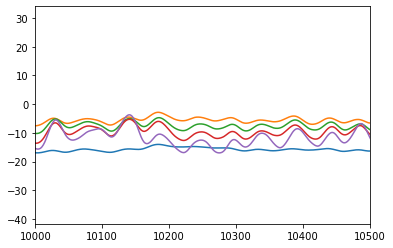

In [15]:
for r in r_list:
    plt.plot(r)
plt.xlim(10000,10500)
# plt.xlim(0,500)

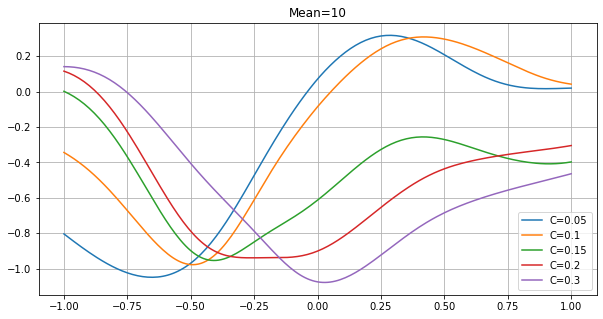

In [16]:
for i in range(len(amp_list)):
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(amp_list[i]/Mean,3)))
plt.legend()
plt.title('Mean='+str(Mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

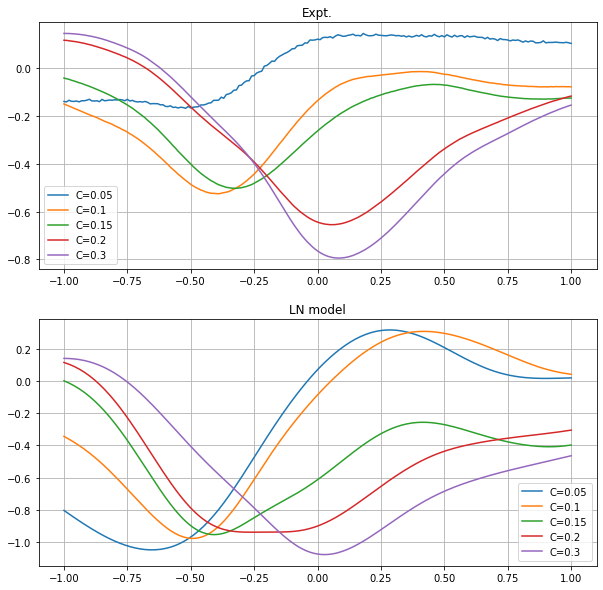

In [17]:
fig, ax = plt.subplots(2,1)
for i in range(len(amp_list)):
    ax[0].plot(timeshift, ExpSTA_list[i][cn-1], label = 'C='+str(round(amp_list[i]/Mean,3)))
    ax[1].plot(timeaxis, DCCM_Xcorr[i], label = 'C='+str(round(amp_list[i]/Mean,3)))

for axi in ax:
    axi.legend()
    axi.grid('on')

ax[0].set_title('Expt.')
ax[1].set_title('LN model')

# fig.suptitle('Expt. Data')
fig.set_size_inches(10,10)